In [22]:
using Plots
using LaTeXStrings
using PyPlot
using LinearAlgebra
using DataFrames

# Tarea - examen 3
## Física Computacional
### Aquino Chapa Martha Abril
Hecho en Julia 🔴🟢🟣

## Problema 1. 
####  Encuentra la solución numérica para la ecuación diferencial $∇^{2}\phi=0$ en dos dimensiones con condiciones a la frontera $\phi(0, y) = \phi(x, 0) = \phi(1, y) = \phi(x, 1) = 0$ y $\phi = 1$ para todos los puntos x, y en dos círculos de radio 1/4 con centros en (0.4, 0.5) y (0.6, 0.5).
#### Dibuje las líneas de campo vectorial que se generan de obtener $-\nabla\phi$.

Iniciamos definiendo la malla con la que trabajaremos, la cual debe cumplir con las condiciones a la frontera dadas.

In [ ]:
function Malla_circ2(x,y,r,V_0=1.0)
    #Definimos el arreglo donde anexaremos el valor de cada potencial
    Mat=zeros(length(x),length(y))
    #Realizamos dos ciclos para llenar las entradas del arreglo Mat
    for i in 2:length(y)-1
        for j in 2:length(x)-1
            #Si elemento x[j],y[i] está en la frontera, le pedimos a la función que la entrada de la matriz sea la condición a la frontera
            if sqrt((x[j]-0.4)^2+(y[i]-0.5)^2 )<=r || sqrt((x[j]-0.6)^2+(y[i]-0.5)^2 )<=r
                Mat[i,j]=V_0
            else
            #Si el elemento de la malla no está en la frontera le pedimos que llene el correspondiente arreglo de la Matriz con un número aleatorio
                Mat[i,j] = rand()
            end
        end
    end
    #Le pedimos a la función que nos regrese la matriz Mat
    return Mat
end 

Probamos nuestra malla para corroborar que cumpla con las condiciones de frontera impuestas.

In [ ]:
#Definimos las x's y y's de nuestro espacio
x_prueba=collect(0:0.01:1)
y_prueba=collect(0:0.01:1)
#Aplicamos la x y y a la malla
malla_prueba=Malla_circ2(x_prueba,y_prueba,0.25)
#Presentamos los valores de la malla como una distribución de potenciales.
heatmap(x_prueba,y_prueba,malla_prueba)

Notamos que se cumplen las condiciones a la frontera, es decir, tener $\phi=1$ en todos los puntos dentro de los dos círculos.

Así que definimos la función que nos permite resolver la ecuación diferencial. Para ello, recordemos que a partir de una discretización es posible encontrar la solución a la ecuación:
$$\nabla^{2}\phi=0, $$
con el método de Jacobi o de relajación que consiste en iterar el promedio de los puntos vecinos de un elemento hasta que converja la solción, la cual está dada por la siguiente expresión
$$\phi_{ij}={\frac{1}{4}}\left(\phi_{i+1,j}+\phi_{i-1,j}+\phi_{i,j+1}+\phi_{i,j-1} \right). $$
Con ello, definimos la siguiente función que implementa el método de relajación.

In [ ]:
function relax(Mat,V_0=1.0)
    #Aplicaremos el método sólo en los puntos interiores puesto que es ahí donde se encuentra bien definido
    #Definimos los elementos x y y que consisten en las filas y columnas de la matriz para determinar la longitud
    #de nuestra malla
    y=Mat[:,1]
    x=Mat[1,:]
    for i in 2:length(y)-1
        for j in 2:length(x)-1
            #Realizamos el método para el elemento i,j de nuestra malla
            if Mat[i,j] !=V_0
                Mat[i,j]=0.25(Mat[i+1,j]+Mat[i-1,j]+Mat[i,j+1]+Mat[i,j-1])
            end
        end
    end
    #regresamos nuestra malla a la cual ya se le aplico el método de relajación.
    return Mat
end

Sin embargo, en la función anterior no se definió en ningún momento la convergencia de la solución. 
Para esto, definimos la siguiente función que aplicará múltiples veces el método de relajación hasta que la convergencia de la solución sea menor al error pedido.

In [ ]:
function met_jacobi(Mat,error=1e-5)
    #Definimos dos elementos, la cuenta que nos marcará las repeticiones del método y el testigo que avalará que la condición de error se cumple
    testigo,cuenta=true,0
    #Abrimos un ciclo el cual se cumplirá hasta que el testigo no corroboré que se cumplió la condición de convergencia
    while testigo==true
        #Se realiza una copia de la malla para poder comparar la nueva solución con la solución anterior y de esa manera
        # determinar cuando se cumple la convergencia
        Mat_old=copy(Mat)
        #Aplicamos el método de relación
        Mat=relax(Mat)
        #Sumamos a la cuenta una aplicación del método de relación en cada ciclo
        cuenta+= 1
        #Anexamos un condicional el cual, si la diferencia entre la malla a la cual se le aplico el método de relación y la
        #anterior, es menor al error, el testigo cambiará a falso y se concluirá con la aplicación del ciclo while
        if maximum(abs.(Mat .- Mat_old))<=error
            testigo=false
        end
    end
    #Al concluir con la convergencia le pedimos a la función que regrese la malla y el número de veces que se aplico el 
    #método de relación
    return Mat,cuenta
end

Ya que poseemos las herramientas para resolver la ecuación diferencial, aplicaremos *met\_jacobi* a la malla que definimos en un principio.

In [ ]:
#Definimos el espacio en x
x1=collect(0:0.01:1)
#Definimos el espacio en y
y1=collect(0:0.01:1)
# Con x, y  y el radio de la circunferencias definimos nuestra malla inicial
ϕ=Malla_circ2(x1,y1,0.25)
#Aplicamos el método de jacobi a la malla
ϕ,num=met_jacobi(ϕ)
#Le pedimos al programa que nos grafique la distribución del potencial
plot!(title="φ[V]",xlabel="x",ylabel="y")
heatmap!(x1,y1,ϕ)

Obteniendo las equipotenciales del potencial obtenido.

In [ ]:
plot!(title="Equipotenciales",xlabel="x",ylabel="y")
contourf!(x1,y1,ϕ)

Para obtener el campo es necesario definir una función que nos regrese el gradiente, debido a que estamos haciendo uso de coordenadas cartesianas y de dos variables, se restringirá a esas variables la función.

In [ ]:
## Definimos una función que nos regrese la parte x del gradiente
function gradiente(x,y,ϕ)
    #Definimos la distancia entre puntos en la malla en el eje x
    hx=x[2]-x[1]
    #Definimos la distancia entre puntos en la malla en el eje y
    hy=y[2]-y[1]
    #Definimos nuestros arreglos donde anexaremos la primera y la segunda componente del gradiente
    gradx=zeros(length(x),length(y))
    grady=zeros(length(x),length(y))
    #Realizamos un ciclo que corra dentro de los elementos anteriores para obtener las derivadas parciales en cartesianas
    for i in 2:length(y)-1
        for j in 2:length(x)-1
            #Definimos la i,j entrada del vector gradiente en x
            gradx[i,j]=(ϕ[i,j+1]-ϕ[i,j-1])/hx
            #Definimos la i,j entrada del vector gradiente en y
            grady[i,j]=(ϕ[i+1,j]-ϕ[i-1,j])/hy
        end
    end
    #Regresamos el gradiente
    return gradx,grady
end

Con ello gráficamos el campo.

In [ ]:
E_x,E_y=-1 .*gradiente_x(x1,y1,ϕ)
streamplot(x1,y1,E_x,E_y)

## Problema 2. 
#### Encuentre la solución a la ecuación de Fourier en 2D con condición a la frontera $\phi(0, y) = \phi(x, 0) = \phi(1, y) = \phi(x, 1) = 0$ y con condición inicial $\phi(x, y, 0) = 0$ para todos los puntos afuera de los dos círculos de radio 1/4 con centros en (0.4, 0.5) y (0.6, 0.5), y $\phi = 1$ para todos los puntos dentro del los dos círculos anteriores. 
#### Puede suponer que el coeficiente de difusión es 1.

En clase se vió le método de Crank-Nicholson, el cual se aplica en los puntos interiores de la malla con la que se trabaja.
Iniciamos entonces definiendo la malla con la que trabajaremos, la cual debe de cumplir con las condiciones iniciales y de frontera.

In [ ]:
function Psi_ini_circ2(x,y)
    Nx,Ny = length(x),length(y)
    phi=zeros(Ny,Nx)
    #cordenada y
    for i in 2:Nx-1
       for j in 2:Ny-1
            #Si se cumple la condición de frontera y condición inicial
            if sqrt(( x[i]-0.4 )^2+(y[j]-0.5)^2)<=(1/4) || sqrt(( x[i]-0.6 )^2+(y[j]-0.5)^2)<=(1/4)
                #Pedimos que phi sea 1
                phi[j,i]=1
            end
        end
    end
    return phi
end

Definimos las funciones que implemental el método de Crank-Nicholson.

In [ ]:
function Mat_evol_CN_2D(x,y,t,D=1.0)
    Nx,Ny=length(x),length(y)
    #Definimos los pasos de las entradas x,y y t
    Δx,Δy,Δt=x[2]-x[1],y[2]-y[1],t[2]-t[1]
    r = (D*Δt)/(2*Δx*Δy)
    println("r = ",r)
    #Definimos nuestras matrices
    A=zeros( (Nx-2)*(Ny-2) ,(Nx-2)*(Ny-2) )
    B=zeros( (Nx-2)*(Ny-2) ,(Nx-2)*(Ny-2) )
    #Definimos los elementos de la diagonal de las matrices A y B
    for i in 1:Nx-2
       for j in 1:Ny-2
            A[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j ]=1+4*r
            
            B[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j ]=1-4*r
        end
    end
    #Definimos los elementos de la diagonal superior e inferior de las matrices A y B
    for i in 1:Nx-2
       for j in 1:Ny-3
            A[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j+1 ]=-r
            A[ (Ny-2)*(i-1)+j+1 , (Ny-2)*(i-1)+j ]=-r
            
            B[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j+1 ]=r
            B[ (Ny-2)*(i-1)+j+1 , (Ny-2)*(i-1)+j ]=r
        end
    end

    # Elementos diagonales de la diagonal superior e inferior
    for i in 1:Nx-3
       for j in 1:Ny-2
            A[ (Ny-2)*(i-1)+j , (Ny-2)*(i)+j ]=-r
            A[ (Ny-2)*(i)+j , (Ny-2)*(i-1)+j ]=-r
            
            B[ (Ny-2)*(i-1)+j , (Ny-2)*(i)+j ]=r
            B[ (Ny-2)*(i)+j , (Ny-2)*(i-1)+j ]=r
        end
    end
    A_inversa=inv(A)
    Evol = A_inversa*B
    return Evol
end

Programando el método de Crack-Nicholson

In [ ]:
function Cranck_Nicholson_2D(Ψ₀,M_evo,t)
   #Vamos a guardar las diagonales
    Nx,Ny,Nt=length(Ψ₀[:,1]),length(Ψ₀[1,:]),length(t)
    Ψ_xy_t=zeros(Nx,Ny,Nt) #Copiando Psi inicial a la solución final
    Ψ_xy_t[:,:,1] = Ψ₀
    Ψ_in_t = reshape( Ψ₀[2:end-1,2:end-1],((Nx-2)*(Ny-2),1))  
    for i in 2:Nt
       Ψ_in_t = M_evo*Ψ_in_t
        Ψ_xy_t[2:end-1,2:end-1,i]=reshape(Ψ_in_t,(Nx-2,Ny-2))
    end
    return Ψ_xy_t
end

Definiendo la malla donde trabajaremos:

In [ ]:
#Nuestra malla para el eje x
x2=collect(0:0.01:1)
#La malla para el eje y
y2=collect(0:0.01:1)
#El intervalo de tiempo donde trabajaremos
t2=collect(0:0.0001:0.02)
#La malla con la condicion inicial
psi_mat2 = Psi_ini_circ2(x2,y2)
#Presentamos la malla inicial como una distribución
heatmap(x2,y2,psi_mat2)

Vemos que cumple con las condiciones iniciales y de frontera, así, podemos inciar a aplicar el método de Crank-Nicholson.

In [ ]:
M_t2 = Mat_evol_CN_2D(x2,y2,t2);

In [ ]:
#Obtemos la solución para diversos tiempos
Psi_total3 = Cranck_Nicholson_2D(psi_mat2,M_t2,t2);

Presentamos la distribución, que podemos tomar como una distribución de calor, a un tiempo t=200.

In [ ]:
heatmap(x2,y2,Psi_total3[:,:,200],clim=(0,1),aspect_ratio=:equal)

Calculando las isotermas a un tiempo t=200

In [ ]:
contourf!(x2,y2,Psi_total3[:,:,200],clim=(0,1),aspect_ratio=:equal)

Mostramos el resultado con una pequeña animación que muestre la evolución del sistema, o difusión de calor.

In [ ]:
mi_peli=@animate for i =1:length(t2)
    heatmap(x2,y2,Psi_total3[:,:,i],clim=(0,1),aspect_ratio=:equal)
end
gif(mi_peli,"dos_circ_calor.gif",fps=20)

## Problema 3
####  Encuentre los estados estacionarios de la ecuación de onda en 2D para una membrana rectangular $L_x = \pi$, $L_y = 2\pi$. Compare la solución numérica de los eigenvalores con la solución analítica. 
#### ¿Qué sucede con la solución si ahora $L_x = \pi$, $L_y=\sqrt{2\pi}$?

Iniciamos definiendo una función que resuelva para ecuación de onda en 2 dimensiones.

In [2]:
function Mat_onda_2D(x,y)
   #Puntos interiores 
    Nx,Ny=length(x),length(y)
    A=zeros(Nx*Ny,Nx*Ny)
    #para la diagonal
    for i in 1:Nx
       for j in 1:Ny
            A[Ny*(i-1)+j,Ny*(i-1)+j]=-4
        end
    end
    #para la diagonal principal
    #Diagonal superior e inferior del bloque principal
    for i in 1:Nx
       for j in 1:Ny-1
            A[Ny*(i-1)+j,Ny*(i-1)+j+1]=1
            A[Ny*(i-1)+j+1,Ny*(i-1)+j]=1
        end
    end
    #
    for i in 1:Nx-1
       for j in 1:Ny
            A[Ny*(i-1)+j,Ny*(i)+j]=1
            A[Ny*(i)+j,Ny*(i-1)+j]=1
        end
    end
    
    return A
end

Mat_onda_2D (generic function with 1 method)

In [3]:
#Definimos puntos en x de la malla de la membrana
x=collect(0:0.04:pi)
#Puntos en y de la membrana
y=collect(0:0.04:(2*pi))
#Debido a que estamos tomando una distancia entre puntos en x y y igual, la distancia entre ellos es
h=x[2]-x[1]
#Definimos la matriz a la cual sacaremos los eigenvalores p
M=Mat_onda_2D(x[2:end-1],y[2:end-1])
#Obtenemos los eigenvalores de la matriz
vals = eigvals(M)
#Obtenemos los nodos de vibración pedidos y los acomodamos de menor a mayor
valores=sort(sqrt.(-vals)/(h))

12012-element Array{Float64,1}:
  1.1242764815419704
  1.419377812589252
  1.8070304481207162
  2.0745144380618163
  2.2395700083539625
  2.248165012091844
  2.5109702481569536
  2.695343560234242
  2.838183639070937
  3.060090308947231
  3.164185160894178
  3.180375522927318
  3.210060662111736
  ⋮
 70.63911955519518
 70.63984663253142
 70.64443252869376
 70.6536956827526
 70.65928900783142
 70.66608117345201
 70.6749301667739
 70.675203050134
 70.68024044841907
 70.68758477243112
 70.69643107417075
 70.7017397409213

Los eigenvalores del problema de una membrana están dados por:
$$\lambda_{nm}=c\pi\sqrt{{\frac{m^2}{a^2}}+{\frac{n^2}{b^2}}} $$

Donde n y m son enteros y a y b corresponden a las longitudes del ancho y largo de la membrana. Entonces definamos algunos eigenvalores y notemos si se encuentran en los obtenidos de manera númerica. Tomando un rango de error de 0.01.

In [4]:
n=collect(1:1:5)
m=collect(1:1:5)
c=299792458
a=π
b=2π
f(n,m)=π*sqrt.(m^2/a^2+n^2/b^2)
λ=[]
for i in n
    for j in m
       push!(λ,f(i,j))
    end
end
#Regresamos los eigenvalores obtenidos y los ordenamos de menor a  mayor
return sort(λ)

25-element Array{Any,1}:
 1.1180339887498947
 1.414213562373095
 1.8027756377319948
 2.0615528128088303
 2.2360679774997894
 2.2360679774997894
 2.5
 2.692582403567252
 2.82842712474619
 3.0413812651491097
 3.162277660168379
 3.2015621187164243
 3.354101966249684
 3.6055512754639896
 3.9051248379533274
 4.031128874149275
 4.123105625617661
 4.272001872658766
 4.472135954999579
 4.716990566028302
 5.024937810560445
 5.099019513592785
 5.2201532544552744
 5.385164807134504
 5.5901699437494745

In [11]:
function repetidos(λ,λp,error=5e3)
    repetidos=[]
    for i in length(λ)
        for j in length(λp)
            if abs(λ[i]-λp[j])<=error
                push!(repetidos,λp)
            else
                false
            end
        end
    end
    return repetidos
end

repetidos (generic function with 2 methods)

In [31]:
data=DataFrame(N=sort(λ),A=valores[1:length(λ)])

,N,A
,Any,Float64
1,1.11803,1.12428
2,1.41421,1.41938
3,1.80278,1.80703
4,2.06155,2.07451
5,2.23607,2.23957
6,2.23607,2.24817
7,2.5,2.51097
8,2.69258,2.69534
9,2.82843,2.83818


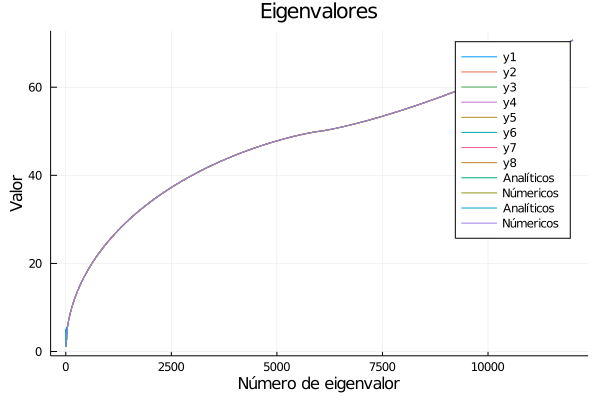

In [21]:
n=length(valores)
plot!(title="Eigenvalores",xlabel="Número de eigenvalor",ylabel="Valor")
plot!(λ,label="Analíticos")
plot!(valores[1:n],label="Númericos")
#plot!(repetidos(λ,valores),"Repetidos")